## Sample vs Population variance

The goal of this notebook is to explore whether the "sample variance" (with the $1 \over n-1$) is actually a better estimate of the population variance.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from tools import histpair

Assume some data from a normal distribution.

In [2]:
dist = stats.norm(0, 1)

Take a bunch of small samples

In [3]:
n_samples = 1000000
sample_size = 5
samples = dist.rvs((n_samples, sample_size))

In [4]:
def mse_var(samples, ddof):
    return ((samples.var(axis=1, ddof=ddof) - 1) ** 2).mean()

def bias_var(samples, ddof):
    return (samples.var(axis=1, ddof=ddof) - 1).mean()

def mae_var(samples, ddof):
    return np.abs((samples.var(axis=1, ddof=ddof) - 1)).mean()

In [5]:
print("MSE using pop: ", mse_var(samples, 0))
print("MSE using sam: ", mse_var(samples, 1))

MSE using pop:  0.3604159587628621
MSE using sam:  0.5009193893484843


Huh. The sample variance is, on average, a **worse** estimate using MSE.

Is it unbiased?

In [6]:
print("Bias using pop: ", bias_var(samples, 0))
print("Bias using sam: ", bias_var(samples, 1))

Bias using pop:  -0.1995688739495806
Bias using sam:  0.0005389075630243692


Yes, it is unbiased.

In [7]:
print("MAE using pop: ", mae_var(samples, 0))
print("MAE using sam: ", mae_var(samples, 1))

MAE using pop:  0.4955280554435639
MAE using sam:  0.5414724864666914


Using mean absolute error it's pretty close.

Let's graph the distribution of computed variances.

/Users/jackbennetto/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


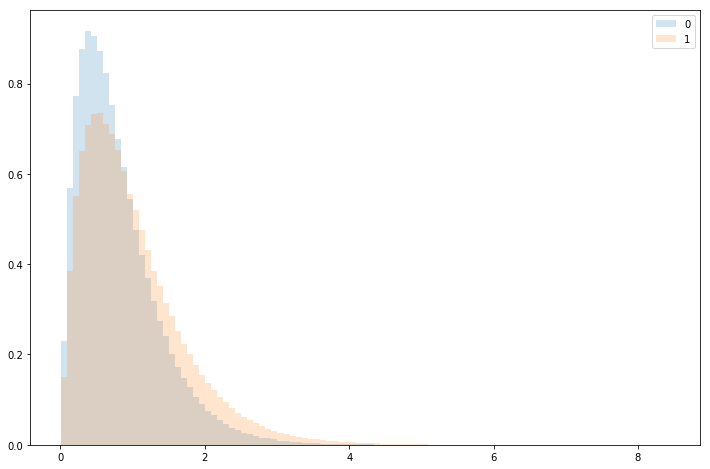

In [8]:
histpair([samples.var(axis=1, ddof=0), samples.var(axis=1, ddof=1)], bins=100)

Note the sample variance (1) is larger (having a smaller denominator).  Even though the bias is zero so the average value is closer, the extreme large values push the MSE up.

Let's try a range of values for the differential degrees of freedom, and see which has the lowest MSE and MAE. We've narrowed it down a bit here.

In [9]:
ddofs = np.arange(-1.2, -0.8, 0.01)
mses = []
for ddof in ddofs:
    mses.append(mse_var(samples, ddof))

Text(0, 0.5, 'MSE')

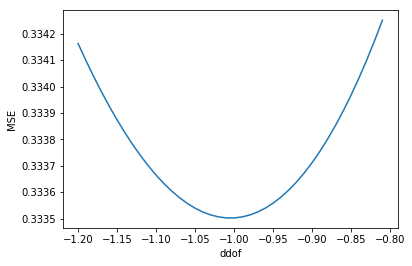

In [10]:
fig, ax = plt.subplots()
ax.plot(ddofs, mses)
ax.set_xlabel('ddof')
ax.set_ylabel('MSE')

That looks as if it has a minimum at -1 (i.e., for the smallest MSE, we should have a denominator of $n+1$, not $n-1$.

In [11]:
ddofs = np.arange(-0.34430, -0.34425, 0.000001)
maes = []
for ddof in ddofs:
    maes.append(mae_var(samples, ddof))

Text(0, 0.5, 'MAE')

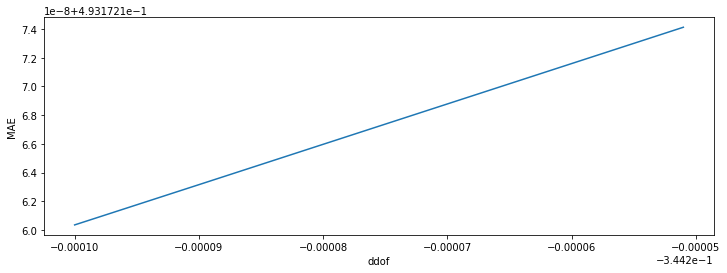

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ddofs, maes)
ax.set_xlabel('ddof')
ax.set_ylabel('MAE')

So that has a minimum of around, ddof=-0.33427.

### MLE

What about the MLE solution?

For two points we can work it out.

Suppose the samples is [-1, 1]. The MLE mean is clearly zero. Looking at the pdf

$$f(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Setting $\mu$ to zero and x to 1,

$$f(1; \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{1}{2\sigma^2}}$$


...and something. The actual answer looks like a variance of 1, which is what we'd get if we had a denominator of n.

Text(0.5, 1.0, 'Likelihood of Variance of Normal Distribution Given Data of [1, -1]')

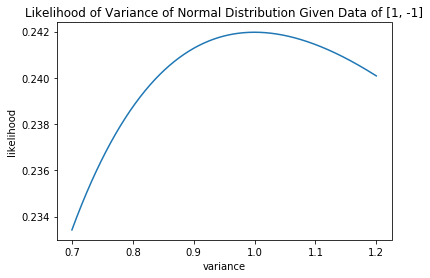

In [13]:
var = np.linspace(0.7, 1.2, 500)
f = np.exp(-1/(2*var))/(2*np.pi*var)**0.5

fig, ax = plt.subplots()
ax.plot(var, f)
ax.set_xlabel('variance')
ax.set_ylabel('likelihood')
ax.set_title('Likelihood of Variance of Normal Distribution Given Data of [1, -1]')

So from assuming that extends to more data, a DDOF of 0 is the MLE solution.

### Bayes

I think there's something to think about here, using a different prior.

In [14]:
import pymc3 as pm

In [15]:
with pm.Model() as model:
    mu = pm.Normal('mu', 0, 1e6)
    sigma = pm.HalfNormal('sigma', 1e6)
    observed = pm.Normal('observed', mu, sigma, observed=[-1, -1, -1, -1, 1, 1, 1, 1])

In [16]:
with model:
    m = pm.find_MAP()

logp = -59.243, ||grad|| = 54.704: 100%|██████████| 19/19 [00:00<00:00, 34.79it/s]  


In [17]:
m['mu'], m['sigma']

(array(4.09903881e-17), array(1.))

That confirms what we thought for the MLE. Let's do a full Bayes solution and get the expectation values.

In [18]:
with model:
    trace = pm.sample(10000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/jackbennetto/anaconda/envs/py36/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, mu]
100%|██████████| 15000/15000 [00:18<00:00, 803.67it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6848549311823703, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/jackbennetto/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1143c1f60>,
      dtype=object)

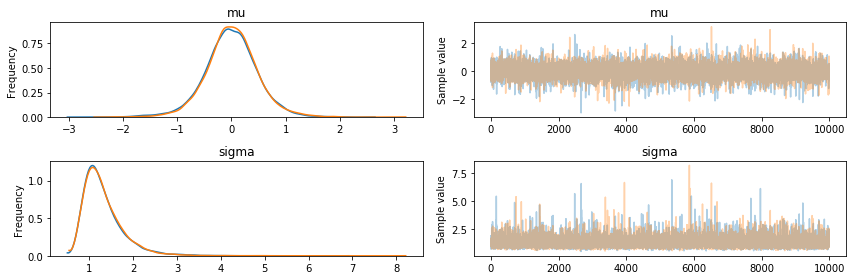

In [19]:
pm.traceplot(trace)

In [20]:
trace['mu'].mean()

-0.003876824913747982

In [21]:
trace['sigma'].mean()

1.3194502472117222

In [22]:
np.median(trace['sigma'])

1.2133365989165172

(0, 5)

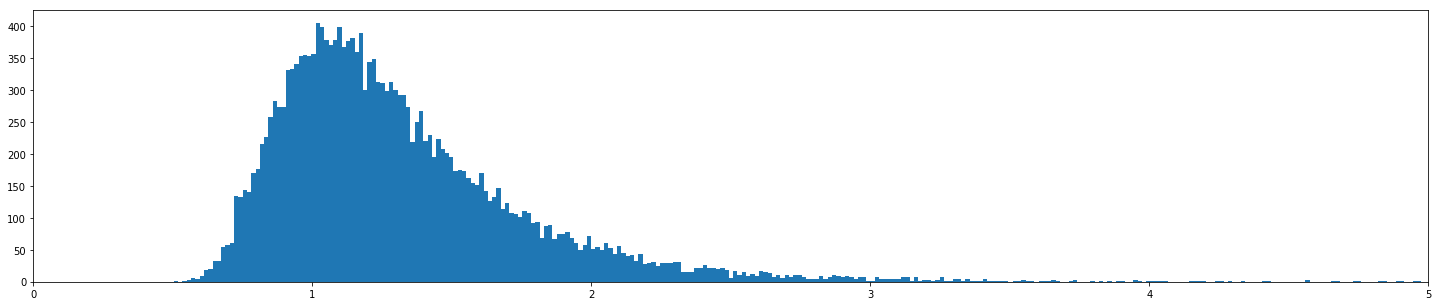

In [23]:
fig, ax = plt.subplots(figsize=(25,5))
ax.hist(trace['sigma'], bins=500)
ax.set_xlim(0, 5)